In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime 
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc


In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
inspector = inspect(engine)

columns = inspector.get_columns('measurement') # get column names
print(columns)

[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Climate Analysis and Exploration

### Precipitation Analysis

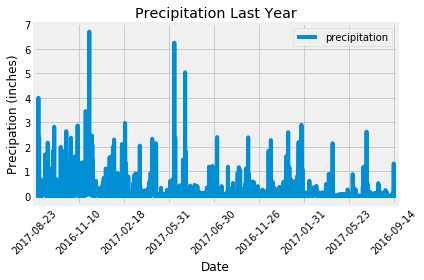

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results 
# Calculate the date 1 year ago from the last data point in the database

last_date = session.query(Measurement).order_by(Measurement.date.desc()).first() # find last date in database

last_date_formatted = datetime.strptime(last_date.date, '%Y-%m-%d') # reformatt date for calucations

year_ago = last_date_formatted - dt.timedelta(days=365) # substract a year from the date

year_ago_str = datetime.strftime(year_ago, '%Y-%m-%d') # format the new date a string



# Perform a query to retrieve the data and precipitation scores
scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago_str).all()


# organize queried results into a list
score_date = [score.date for score in scores]
score_prcp = [score.prcp for score in scores]


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(scores, columns = ['date', 'precipitation'])
df.set_index('date', inplace = True)
df.head()


# Sort the dataframe by date and drop null values
df.dropna(inplace = True)
df.sort_values(by = 'date')


# Use Pandas Plotting with Matplotlib to plot the data
df.iloc[::-1].plot(title = "Precipitation Last Year")

plt.ylabel('Precipation (inches)')
plt.xlabel('Date')
plt.xticks(rotation = 45)

plt.tight_layout()

plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [22]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station.station).count()

print (f"There are a total of {num_stations} stations.")

There are a total of 9 stations.


In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()

print(f"{station_activity[0][0]} has the most obervations with {station_activity[0][1]}")
print(f"")
print("The other stations in descending order are as follows...")
count = 0
for station in station_activity:
    count += 1
    print (f"  {count}. {station[0]}, {station[1]} observations")
    
#station_activity

USC00519281 has the most obervations with 2772

The other stations in descending order are as follows...
  1. USC00519281, 2772 observations
  2. USC00519397, 2724 observations
  3. USC00513117, 2709 observations
  4. USC00519523, 2669 observations
  5. USC00516128, 2612 observations
  6. USC00514830, 2202 observations
  7. USC00511918, 1979 observations
  8. USC00517948, 1372 observations
  9. USC00518838, 511 observations


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_activity[0][0]).all()

print(f"The most active station is {station_activity[0][0]}.")
print("")
print(f"The lowest temperature recorded at this station was {most_active_station[0][0]}")
print(f"The highest temperature recorded at this station was {most_active_station[0][1]}")
print(f"The average temperature recorded at this station was {most_active_station[0][2]}")

#most_active_station

The most active station is USC00519281.

The lowest temperature recorded at this station was 54.0
The highest temperature recorded at this station was 85.0
The average temperature recorded at this station was 71.66378066378067


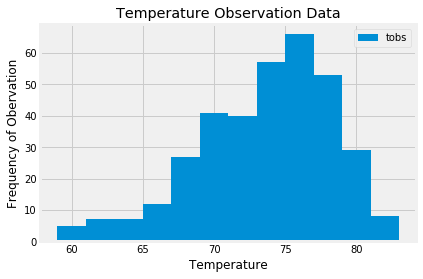

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_obs = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_ago_str).\
    filter(Measurement.station == station_activity[0][0]).all()

# convert quiered results into a dataframe
temp_df = pd.DataFrame(temp_obs)

# create a histogram of dataframe
temp_df.plot.hist(bins = 12, title = 'Temperature Observation Data');

# add x and y labels
plt.xlabel('Temperature');
plt.ylabel('Frequency of Obervation');